In [14]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

data = pd.read_csv('network_trafiic_dataset.csv')

data = data.drop(['No.','Info'], axis=1)

data = pd.get_dummies(data, columns=['Source','Destination','Protocol'])

scaler = StandardScaler()
data[['Time', 'Length']] = scaler.fit_transform(data[['Time', 'Length']])

data['label'] = np.where(data.index > len(data) * 0.8,1,0)

x = data.drop('label', axis=1)
y = data['label']

x_train, x_temp, y_train, y_temp = train_test_split(x,y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)


(275895, 699) (59121, 699) (59121, 699)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

Accuracy:  1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47406
           1       1.00      1.00      1.00     11715

    accuracy                           1.00     59121
   macro avg       1.00      1.00      1.00     59121
weighted avg       1.00      1.00      1.00     59121



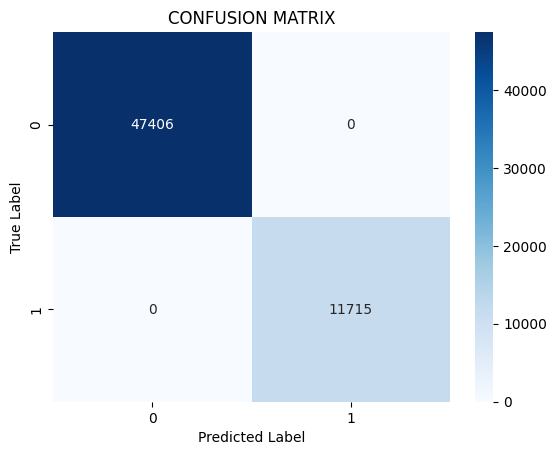

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CONFUSION MATRIX")
plt.show()

In [ ]:
#FLAGGING THE WHOLE DATASET
import pandas as pd
import numpy as np

malicious_ips_path = 'bad_ips.csv'
malicious_ips_data = pd.read_csv(malicious_ips_path)

print("Columns in bad_ips.csv:", malicious_ips_data.columns)


ip_column = malicious_ips_data.columns[0]
malicious_ips = set(malicious_ips_data[ip_column])

print(f"Number of malicious IPs: {len(malicious_ips)}")
print(f"Sample malicious IPs: {list(malicious_ips)[:5]}")

y_pred = rf_model.predict(x_test)
flagged_ips = []


malicious_count = 0


for pred, (_, row) in zip(y_pred, x_test.iterrows()):
    if pred == 1:  # If predicted as malicious
        malicious_count += 1
       
        for col in x_test.columns:
            if col.startswith('Source_') and row[col] == 1:
                ip = col.split('_', 1)[1]  
                if ip in malicious_ips:
                    flagged_ips.append(ip)
                    print(f"Flagged IP: {ip}")
                elif ip in list(malicious_ips)[:5]:
                    print(f"IP {ip} found in x_test but not flagged. Prediction: {pred}")


flagged_ips = sorted(set(flagged_ips))

print(f"\nTotal predictions: {len(y_pred)}")
print(f"Malicious predictions: {malicious_count}")
print(f"Flagged IPs for further investigation: {flagged_ips}")
print(f"Number of flagged IPs: {len(flagged_ips)}")


source_columns = [col for col in x_test.columns if col.startswith('Source_')]
print(f"\nSample 'Source_' columns: {source_columns[:10]}")


matching_columns = [col for col in source_columns if any(str(ip) in col for ip in malicious_ips)]
print(f"\nMatching 'Source_' columns: {matching_columns}")

In [20]:
#FLAGGING THE FIRST FEW ROWS OF RF.MODEL
import pandas as pd
import numpy as np


malicious_ips_path = 'bad_ips.csv'
malicious_ips_data = pd.read_csv(malicious_ips_path)

print("Columns in bad_ips.csv:", malicious_ips_data.columns)


ip_column = malicious_ips_data.columns[0]
malicious_ips = set(malicious_ips_data[ip_column].astype(str))  # Convert to string

print(f"Number of malicious IPs: {len(malicious_ips)}")
print(f"Sample malicious IPs: {list(malicious_ips)[:5]}")


subset_size = min(1000, len(x_test))  
x_test_subset = x_test.iloc[:subset_size]
y_pred_subset = rf_model.predict(x_test_subset)


flagged_ips = []


malicious_count = 0


source_columns = [col for col in x_test_subset.columns if col.startswith('Source_')]


for pred, row in zip(y_pred_subset, x_test_subset[source_columns].itertuples()):
    if pred == 1:  
        malicious_count += 1
        for i, value in enumerate(row[1:], start=0):  
            if value == 1:
                ip = source_columns[i].split('_', 1)[1]  
                if ip in malicious_ips:
                    flagged_ips.append(ip)
                    print(f"Flagged IP: {ip}")
                elif ip in list(malicious_ips)[:5]:  
                    print(f"IP {ip} found in x_test but not flagged. Prediction: {pred}")


flagged_ips = sorted(set(flagged_ips))

print(f"\nTotal predictions in subset: {len(y_pred_subset)}")
print(f"Malicious predictions in subset: {malicious_count}")
print(f"Flagged IPs for further investigation: {flagged_ips}")
print(f"Number of flagged IPs: {len(flagged_ips)}")


print(f"\nSample 'Source_' columns: {source_columns[:10]}")


matching_columns = [col for col in source_columns if any(str(ip) in col for ip in malicious_ips)]
print(f"\nMatching 'Source_' columns: {matching_columns}")

Columns in bad_ips.csv: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port',
       'Destination Port', 'bad_packet'],
      dtype='object')
Number of malicious IPs: 3245180
Sample malicious IPs: ['30.530563586', '32.203724775', '31.809930226', '34.375744887', '22.517321262']

Total predictions in subset: 1000
Malicious predictions in subset: 198
Flagged IPs for further investigation: []
Number of flagged IPs: 0

Sample 'Source_' columns: ['Source_0.0.0.0', 'Source_10.25.3.2', 'Source_10.27.3.2', 'Source_104.102.248.194', 'Source_104.102.248.210', 'Source_104.113.27.171', 'Source_104.113.29.107', 'Source_104.114.79.211', 'Source_104.114.79.75', 'Source_104.123.153.10']

Matching 'Source_' columns: ['Source_0.0.0.0']


In [21]:
#FLAGGING THE LAST FEW ROWS OF RF.MODEL

import pandas as pd
import numpy as np


malicious_ips_path = 'bad_ips.csv'
malicious_ips_data = pd.read_csv(malicious_ips_path)

print("Columns in bad_ips.csv:", malicious_ips_data.columns)


ip_column = malicious_ips_data.columns[0]
malicious_ips = set(malicious_ips_data[ip_column].astype(str))  # Convert to string

print(f"Number of malicious IPs: {len(malicious_ips)}")
print(f"Sample malicious IPs: {list(malicious_ips)[:5]}")


y_pred = rf_model.predict(x_test)


malicious_indices = np.where(y_pred == 1)[0]

print(f"Total predictions: {len(y_pred)}")
print(f"Malicious predictions: {len(malicious_indices)}")


flagged_ips = []


source_columns = [col for col in x_test.columns if col.startswith('Source_')]


for idx in malicious_indices:
    row = x_test.iloc[idx]
    for col in source_columns:
        if row[col] == 1:
            ip = col.split('_', 1)[1]  
            if ip in malicious_ips:
                flagged_ips.append(ip)
                print(f"Flagged IP: {ip} at index {idx}")
            elif ip in list(malicious_ips)[:5]:  
                print(f"IP {ip} found in x_test but not flagged. Index: {idx}")


flagged_ips = sorted(set(flagged_ips))

print(f"\nFlagged IPs for further investigation: {flagged_ips}")
print(f"Number of flagged IPs: {len(flagged_ips)}")


print(f"\nSample 'Source_' columns: {source_columns[:10]}")


matching_columns = [col for col in source_columns if any(str(ip) in col for ip in malicious_ips)]
print(f"\nMatching 'Source_' columns: {matching_columns}")


print("\nLast few rows of x_test:")
print(x_test.iloc[-5:, :5]) 

Columns in bad_ips.csv: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port',
       'Destination Port', 'bad_packet'],
      dtype='object')
Number of malicious IPs: 3245180
Sample malicious IPs: ['30.530563586', '32.203724775', '31.809930226', '34.375744887', '22.517321262']
Total predictions: 59121
Malicious predictions: 11715

Flagged IPs for further investigation: []
Number of flagged IPs: 0

Sample 'Source_' columns: ['Source_0.0.0.0', 'Source_10.25.3.2', 'Source_10.27.3.2', 'Source_104.102.248.194', 'Source_104.102.248.210', 'Source_104.113.27.171', 'Source_104.113.29.107', 'Source_104.114.79.211', 'Source_104.114.79.75', 'Source_104.123.153.10']

Matching 'Source_' columns: ['Source_0.0.0.0']

Last few rows of x_test:
            Time    Length  Source_0.0.0.0  Source_10.25.3.2  Source_10.27.3.2
210421  0.041990  0.631049           False             False             False
235575  0.222431  0.568950           False             False             False
7761

In [1]:
import pandas as pd
import numpy as np


data = {
    'Source_192.168.1.1': [1, 0, 0, 1, 0],
    'Source_10.0.0.1': [0, 1, 0, 0, 1],
    'Source_172.16.0.1': [0, 0, 1, 0, 0],
    'Destination_192.168.1.2': [0, 1, 0, 1, 0],
    'Destination_10.0.0.2': [1, 0, 0, 0, 1],
    'Destination_172.16.0.2': [0, 0, 1, 0, 0],
    'Protocol_TCP': [1, 1, 0, 1, 0],
    'Protocol_UDP': [0, 0, 1, 0, 1],
    'Label': [0, 1, 0, 1, 1]  
}

df = pd.DataFrame(data)
df.to_csv('sample_network_traffic.csv', index=False)
print("sample_network_traffic.csv created")

sample_network_traffic.csv created


In [2]:
bad_ips = pd.DataFrame({'IP': ['10.0.0.1', '172.16.0.1']})
bad_ips.to_csv('sample_bad_ips.csv', index=False)
print("sample_bad_ips.csv created")

sample_bad_ips.csv created


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier


network_data = pd.read_csv('sample_network_traffic.csv')

X = network_data.drop('Label', axis=1)
y = network_data['Label']


rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X, y)


malicious_ips_path = 'sample_bad_ips.csv'
malicious_ips_data = pd.read_csv(malicious_ips_path)

print("Columns in sample_bad_ips.csv:", malicious_ips_data.columns)


ip_column = malicious_ips_data.columns[0]
malicious_ips = set(malicious_ips_data[ip_column].astype(str))  # Convert to string

print(f"Number of malicious IPs: {len(malicious_ips)}")
print(f"Malicious IPs: {list(malicious_ips)}")


y_pred = rf_model.predict(X)


malicious_indices = np.where(y_pred == 1)[0]

print(f"Total predictions: {len(y_pred)}")
print(f"Malicious predictions: {len(malicious_indices)}")


flagged_ips = []


source_columns = [col for col in X.columns if col.startswith('Source_')]

for idx, row in X.iterrows():
    for col in source_columns:
        if row[col] == 1:
            ip = col.split('_', 1)[1] 
            if ip in malicious_ips:
                flagged_ips.append(ip)
                print(f"Flagged IP: {ip} at index {idx}. Predicted: {y_pred[idx]}, Actual: {y[idx]}")


flagged_ips = sorted(set(flagged_ips))

print(f"\nFlagged IPs for further investigation: {flagged_ips}")
print(f"Number of flagged IPs: {len(flagged_ips)}")





X['is_malicious'] = X[source_columns].apply(lambda row: any(col.split('_', 1)[1] in malicious_ips for col, val in row.items() if val == 1), axis=1)

accuracy = (y == X['is_malicious']).mean()
print(f"\nAccuracy of malicious IP identification: {accuracy:.2f}")


misclassified = X[y != X['is_malicious']]
print("\nMisclassified rows:")
print(misclassified)

Columns in sample_bad_ips.csv: Index(['IP'], dtype='object')
Number of malicious IPs: 2
Malicious IPs: ['10.0.0.1', '172.16.0.1']
Total predictions: 5
Malicious predictions: 3
Flagged IP: 10.0.0.1 at index 1. Predicted: 1, Actual: 1
Flagged IP: 172.16.0.1 at index 2. Predicted: 0, Actual: 0
Flagged IP: 10.0.0.1 at index 4. Predicted: 1, Actual: 1

Flagged IPs for further investigation: ['10.0.0.1', '172.16.0.1']
Number of flagged IPs: 2

Accuracy of malicious IP identification: 0.60

Misclassified rows:
   Source_192.168.1.1  Source_10.0.0.1  Source_172.16.0.1  \
2                   0                0                  1   
3                   1                0                  0   

   Destination_192.168.1.2  Destination_10.0.0.2  Destination_172.16.0.2  \
2                        0                     0                       1   
3                        1                     0                       0   

   Protocol_TCP  Protocol_UDP  is_malicious  
2             0             1   